In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/106_cyt01.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/094_cyt02.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/001_cyt08.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/019_nuc09.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/045_nuc02.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/096_nuc08.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/042_nuc01.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/034_nuc05.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/041_nuc05.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/096_nuc07.dat
/kaggle/input/cervical-cancer-largest-dataset-sipa

In [3]:
import os
import shutil
import random

# Exact dataset path
input_dir = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed"

# Output folder
output_dir = "/kaggle/working/split_dataset"
splits = ['train', 'test']
for split in splits:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

# Split ratios
train_ratio = 0.8   # 80% train
test_ratio = 0.2    # 20% test
random.seed(42)

# Get all class folders (top-level)
classes = [d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))]

for cls in classes:
    class_path = os.path.join(input_dir, cls)
    
    # Handle nested im_Dyskeratotic/im_Dyskeratotic automatically
    subdirs = [os.path.join(class_path, d) for d in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, d))]
    if len(subdirs) == 1 and cls in subdirs[0]:
        class_path = subdirs[0]

    # Collect all image files (.bmp, .jpg, .jpeg, .png)
    all_images = []
    for root, dirs, files in os.walk(class_path):
        for f in files:
            if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png')):
                rel_path = os.path.relpath(os.path.join(root, f), class_path)
                all_images.append(rel_path)
    random.shuffle(all_images)

    n_total = len(all_images)
    n_train = int(n_total * train_ratio)

    train_files = all_images[:n_train]
    test_files = all_images[n_train:]

    def copy_files(file_list, split):
        for rel_path in file_list:
            src = os.path.join(class_path, rel_path)
            dst = os.path.join(output_dir, split, cls, rel_path)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy2(src, dst)

    copy_files(train_files, 'train')
    copy_files(test_files, 'test')

    print(f"{cls} -> Train: {len(train_files)}, Test: {len(test_files)}")

print("✅ Done. Train/Test splits saved to:", output_dir)


im_Parabasal -> Train: 716, Test: 179
im_Dyskeratotic -> Train: 828, Test: 208
im_Metaplastic -> Train: 851, Test: 213
im_Superficial-Intermediate -> Train: 765, Test: 192
im_Koilocytotic -> Train: 850, Test: 213
✅ Done. Train/Test splits saved to: /kaggle/working/split_dataset


In [4]:
# Step 1: Load Dataset (common for all techniques)
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
data_dir = "/kaggle/working/split_dataset"

img_size = (128, 128)   # Resize all images
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(data_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="sparse",  # numeric labels
    shuffle=True
)

test_gen = datagen.flow_from_directory(
    os.path.join(data_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=False
)

# Convert full dataset into numpy arrays
X_train, y_train = [], []
for i in range(len(train_gen)):
    X, y = train_gen[i]
    X_train.append(X)
    y_train.append(y)
X_train = np.vstack(X_train)
y_train = np.concatenate(y_train)

X_test, y_test = [], []
for i in range(len(test_gen)):
    X, y = test_gen[i]
    X_test.append(X)
    y_test.append(y)
X_test = np.vstack(X_test)
y_test = np.concatenate(y_test)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

# Merge train + test for 5-fold CV
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

2025-09-17 13:57:46.108505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758117466.464668      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758117466.560083      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 4010 images belonging to 5 classes.
Found 1005 images belonging to 5 classes.
Train: (4010, 128, 128, 3) (4010,)
Test : (1005, 128, 128, 3) (1005,)


✅ Dataset Loaded: (776, 128, 128, 3) (776,)

🔹 Extracting handcrafted features...
✅ Features extracted: (776, 19)

🔹 Training SVM...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
✅ Best SVM params: {'C': 5, 'gamma': 0.5}
SVM Accuracy: 0.9974226804123711
                             precision    recall  f1-score   support

            im_Dyskeratotic       1.00      1.00      1.00       181
            im_Koilocytotic       1.00      0.99      0.99       191
             im_Metaplastic       1.00      1.00      1.00       224
               im_Parabasal       0.99      1.00      0.99        84
im_Superficial-Intermediate       1.00      1.00      1.00        96

                   accuracy                           1.00       776
                  macro avg       1.00      1.00      1.00       776
               weighted avg       1.00      1.00      1.00       776


🔹 Training MLP...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MLP Accuracy: 0.5244845360824743
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.52      0.42      0.47       181
            im_Koilocytotic       0.49      0.53      0.51       191
             im_Metaplastic       0.52      0.56      0.54       224
               im_Parabasal       0.62      0.77      0.69        84
im_Superficial-Intermediate       0.51      0.40      0.45        96

                   accuracy                           0.52       776
                  macro avg       0.53      0.54      0.53       776
               weighted avg       0.52      0.52      0.52       776


================ CNN Training ================

🔹 Training fold 1...
Epoch 1/10


I0000 00:00:1758118176.379203     108 service.cc:148] XLA service 0x7a3ac8c0ddb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758118176.380629     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758118176.380658     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758118176.711475     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2878 - loss: 4.1232

I0000 00:00:1758118180.046685     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.2874 - loss: 3.7233 - val_accuracy: 0.0000e+00 - val_loss: 4.3248
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4556 - loss: 1.2961 - val_accuracy: 0.0000e+00 - val_loss: 3.3381
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5486 - loss: 1.1163 - val_accuracy: 0.0000e+00 - val_loss: 3.9589
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5582 - loss: 1.0635 - val_accuracy: 0.0000e+00 - val_loss: 4.9800
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6550 - loss: 0.8600 - val_accuracy: 0.0000e+00 - val_loss: 3.0046
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6368 - loss: 0.8708 - val_accuracy: 0.0000e+00 - val_loss: 3.3995
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6820 - loss: 0.8508 - val_accuracy: 0.0000e+00 - val_loss: 4.9401
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7068 - loss: 0.7664 - val_ac

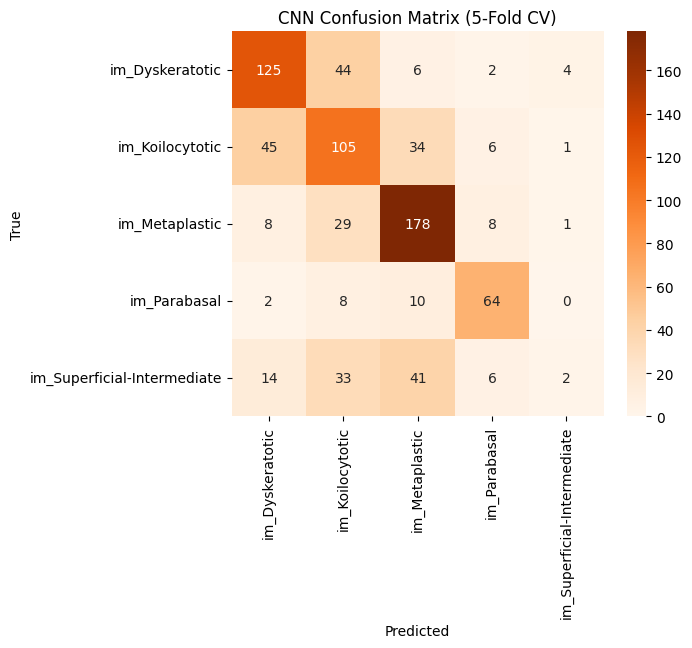

In [10]:
# Baseline Code for MLP SVM and CNN

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops, label
import tensorflow as tf

# ================================
# Step 1: Dataset Setup
# ================================
dataset_dir = "/kaggle/working/split_dataset/train"
img_size = (128, 128)

X_images, y_labels = [], []
classes = sorted(os.listdir(dataset_dir))
class_to_idx = {cls: i for i, cls in enumerate(classes)}

for cls in classes:
    folder = os.path.join(dataset_dir, cls)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg','.png','.jpeg','.bmp')):
            path = os.path.join(folder, fname)
            img = cv2.imread(path)
            img = cv2.resize(img, img_size)
            X_images.append(img)
            y_labels.append(class_to_idx[cls])

X_images = np.array(X_images, dtype="float32") / 255.0  # normalize
y_labels = np.array(y_labels)

print("✅ Dataset Loaded:", X_images.shape, y_labels.shape)


# ================================
# Step 2: Handcrafted Features
# ================================
def extract_features(image):
    features = []

    gray = cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_BGR2GRAY)

    # Intensity
    features.append(np.mean(gray))
    features.append(np.std(gray))
    features.append(np.var(gray))
    features.append(np.mean(cv2.Laplacian(gray, cv2.CV_64F)))
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist /= hist.sum()
    entropy = -np.sum(hist*np.log2(hist+1e-7))
    features.append(entropy)

    # Texture
    glcm = graycomatrix(gray, distances=[1], angles=[0], symmetric=True, normed=True)
    features.append(graycoprops(glcm, 'contrast')[0,0])
    features.append(graycoprops(glcm, 'dissimilarity')[0,0])
    features.append(graycoprops(glcm, 'homogeneity')[0,0])
    features.append(graycoprops(glcm, 'energy')[0,0])
    features.append(graycoprops(glcm, 'correlation')[0,0])

    # Shape
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    labels = label(thresh)
    props = regionprops(labels)
    if len(props) > 0:
        prop = max(props, key=lambda p: p.area)
        features.extend([
            prop.area,
            prop.major_axis_length,
            prop.minor_axis_length,
            prop.eccentricity,
            prop.orientation,
            prop.equivalent_diameter,
            prop.solidity,
            prop.extent
        ])
    else:
        features.extend([0]*8)

    return features


print("\n🔹 Extracting handcrafted features...")
all_features = [extract_features(img) for img in X_images]

df = pd.DataFrame(all_features, columns=[f"f{i}" for i in range(len(all_features[0]))])
df["class"] = y_labels
print("✅ Features extracted:", df.shape)

X_feats = df.drop(columns=["class"]).values
y_feats = df["class"].values

scaler = StandardScaler()
X_feats = scaler.fit_transform(X_feats)

# --- SVM ---
print("\n🔹 Training SVM...")
param_grid = {"C": [0.1,1,5], "gamma": [0.5,1,2]}
grid = GridSearchCV(SVC(kernel="rbf"), param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_feats, y_feats)
svm_best = grid.best_estimator_
y_pred_svm = svm_best.predict(X_feats)

print("✅ Best SVM params:", grid.best_params_)
print("SVM Accuracy:", accuracy_score(y_feats, y_pred_svm))
print(classification_report(y_feats, y_pred_svm, target_names=classes))


# --- MLP ---
print("\n🔹 Training MLP...")
mlp = MLPClassifier(hidden_layer_sizes=(50,), activation="tanh", solver="sgd",
                    max_iter=500, random_state=42)
mlp.fit(X_feats, y_feats)
y_pred_mlp = mlp.predict(X_feats)

print("MLP Accuracy:", accuracy_score(y_feats, y_pred_mlp))
print(classification_report(y_feats, y_pred_mlp, target_names=classes))


# ================================
# Step 3: CNN with 5-Fold CV
# ================================
print("\n================ CNN Training ================")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_preds, all_true = [], []

fold = 1
for train_idx, test_idx in skf.split(X_images, y_labels):
    print(f"\n🔹 Training fold {fold}...")
    fold += 1

    X_tr, X_te = X_images[train_idx], X_images[test_idx]
    y_tr, y_te = y_labels[train_idx], y_labels[test_idx]

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=img_size+(3,)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(classes), activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_tr, y_tr, epochs=10, batch_size=32, verbose=1, validation_split=0.1)

    preds = np.argmax(model.predict(X_te), axis=1)
    all_preds.extend(preds)
    all_true.extend(y_te)

print("\n✅ CNN Report:\n", classification_report(all_true, all_preds, target_names=classes))

cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=classes, yticklabels=classes)
plt.title("CNN Confusion Matrix (5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


✅ Dataset Loaded: (776, 224, 224, 3) (776,)

🔹 Extracting handcrafted features...
✅ Features extracted: (776, 19)

🔹 Training SVM...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
✅ Best SVM params: {'C': 10, 'gamma': 0.1}
SVM Accuracy: 0.9239690721649485
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.95      0.90      0.92       181
            im_Koilocytotic       0.92      0.90      0.91       191
             im_Metaplastic       0.91      0.95      0.93       224
               im_Parabasal       0.90      0.99      0.94        84
im_Superficial-Intermediate       0.95      0.92      0.93        96

                   accuracy                           0.92       776
                  macro avg       0.93      0.93      0.93       776
               weighted avg       0.92      0.92      0.92       776


🔹 Training MLP...
MLP Accuracy: 1.0
                             precision    recall  f1-score   support



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.1768 - loss: 1.9981 - val_accuracy: 0.2372 - val_loss: 2.1113 - learning_rate: 1.0000e-04
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step - accuracy: 0.1763 - loss: 1.9568 - val_accuracy: 0.2372 - val_loss: 1.8782 - learning_rate: 1.0000e-04
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - accuracy: 0.2857 - loss: 1.8078 - val_accuracy: 0.2372 - val_loss: 1.7107 - learning_rate: 1.0000e-04
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 328ms/step - accuracy: 0.2247 - loss: 1.8452 - val_accuracy: 0.2372 - val_loss: 1.6351 - learning_rate: 1.0000e-04
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - accuracy: 0.2366 - loss: 1.7402 - val_accuracy: 0.2308 - val_loss: 1.6000 - learning_rate: 1.0000e-04
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step - accuracy: 0.2845 - loss: 1.7227 - val_accuracy: 0.2372 - val_loss: 1.5659 - learning_rate: 1.0000e-04
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - accuracy: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


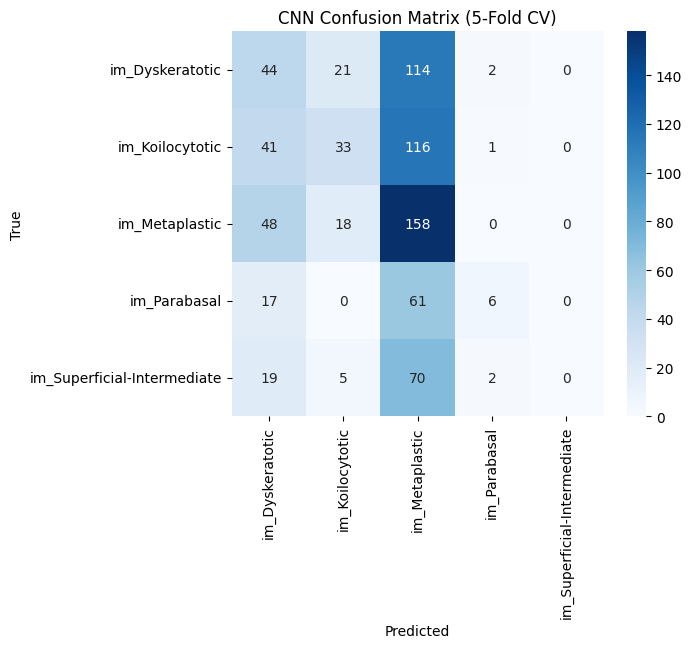

In [20]:
# ================================
# Improved Code for SVM, MLP, CNN
# ================================

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops, label

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ================================
# Step 1: Dataset Setup
# ================================
dataset_dir = "/kaggle/working/split_dataset/train"
img_size = (224, 224)   # larger size for transfer learning

X_images, y_labels = [], []
classes = sorted(os.listdir(dataset_dir))
class_to_idx = {cls: i for i, cls in enumerate(classes)}

for cls in classes:
    folder = os.path.join(dataset_dir, cls)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg','.png','.jpeg','.bmp')):
            path = os.path.join(folder, fname)
            img = cv2.imread(path)
            img = cv2.resize(img, img_size)
            X_images.append(img)
            y_labels.append(class_to_idx[cls])

X_images = np.array(X_images, dtype="float32") / 255.0
y_labels = np.array(y_labels)

print("✅ Dataset Loaded:", X_images.shape, y_labels.shape)


# ================================
# Step 2: Handcrafted Features
# ================================
def extract_features(image):
    features = []
    gray = cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_BGR2GRAY)

    # Intensity
    features.append(np.mean(gray))
    features.append(np.std(gray))
    features.append(np.var(gray))
    features.append(np.mean(cv2.Laplacian(gray, cv2.CV_64F)))
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist /= hist.sum()
    entropy = -np.sum(hist*np.log2(hist+1e-7))
    features.append(entropy)

    # Texture
    glcm = graycomatrix(gray, distances=[1], angles=[0], symmetric=True, normed=True)
    features.append(graycoprops(glcm, 'contrast')[0,0])
    features.append(graycoprops(glcm, 'dissimilarity')[0,0])
    features.append(graycoprops(glcm, 'homogeneity')[0,0])
    features.append(graycoprops(glcm, 'energy')[0,0])
    features.append(graycoprops(glcm, 'correlation')[0,0])

    # Shape
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    labels = label(thresh)
    props = regionprops(labels)
    if len(props) > 0:
        prop = max(props, key=lambda p: p.area)
        features.extend([
            prop.area,
            prop.major_axis_length,
            prop.minor_axis_length,
            prop.eccentricity,
            prop.orientation,
            prop.equivalent_diameter,
            prop.solidity,
            prop.extent
        ])
    else:
        features.extend([0]*8)

    return features

print("\n🔹 Extracting handcrafted features...")
all_features = [extract_features(img) for img in X_images]
df = pd.DataFrame(all_features, columns=[f"f{i}" for i in range(len(all_features[0]))])
df["class"] = y_labels
print("✅ Features extracted:", df.shape)

X_feats = df.drop(columns=["class"]).values
y_feats = df["class"].values

scaler = StandardScaler()
X_feats = scaler.fit_transform(X_feats)

# --- SVM ---
print("\n🔹 Training SVM...")
param_grid = {"C": [0.1,1,10], "gamma": [0.01,0.1,1]}
grid = GridSearchCV(SVC(kernel="rbf", probability=True), param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_feats, y_feats)
svm_best = grid.best_estimator_
y_pred_svm = svm_best.predict(X_feats)

print("✅ Best SVM params:", grid.best_params_)
print("SVM Accuracy:", accuracy_score(y_feats, y_pred_svm))
print(classification_report(y_feats, y_pred_svm, target_names=classes))

# --- MLP ---
print("\n🔹 Training MLP...")
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation="relu", solver="adam",
                    max_iter=1000, random_state=42, alpha=0.001)
mlp.fit(X_feats, y_feats)
y_pred_mlp = mlp.predict(X_feats)

print("MLP Accuracy:", accuracy_score(y_feats, y_pred_mlp))
print(classification_report(y_feats, y_pred_mlp, target_names=classes))


# ================================
# Step 3: CNN with Transfer Learning
# ================================
print("\n================ CNN Training ================")

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_preds, all_true = [], []

fold = 1
for train_idx, test_idx in skf.split(X_images, y_labels):
    print(f"\n🔹 Training fold {fold}...")
    fold += 1

    X_tr, X_te = X_images[train_idx], X_images[test_idx]
    y_tr, y_te = y_labels[train_idx], y_labels[test_idx]

    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=img_size+(3,))
    base_model.trainable = False   # Freeze base for feature extraction

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    preds = Dense(len(classes), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=preds)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1)
    ]

    model.fit(datagen.flow(X_tr, y_tr, batch_size=32),
              epochs=30,
              validation_data=(X_te, y_te),
              callbacks=callbacks,
              verbose=1)

    preds = np.argmax(model.predict(X_te), axis=1)
    all_preds.extend(preds)
    all_true.extend(y_te)

print("\n✅ CNN Report:\n", classification_report(all_true, all_preds, target_names=classes))

cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("CNN Confusion Matrix (5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


✅ Data: (776, 80, 80, 3) (776,)

🔹 Fold 1/5
Train size after augmentation: (2480, 80, 80, 3)
Fold report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.7812    0.6757    0.7246        37
            im_Koilocytotic     0.5273    0.7632    0.6237        38
             im_Metaplastic     0.6250    0.6667    0.6452        45
               im_Parabasal     1.0000    0.8125    0.8966        16
im_Superficial-Intermediate     0.5000    0.2000    0.2857        20

                   accuracy                         0.6474       156
                  macro avg     0.6867    0.6236    0.6351       156
               weighted avg     0.6607    0.6474    0.6385       156


🔹 Fold 2/5
Train size after augmentation: (2484, 80, 80, 3)
Fold report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.8276    0.6667    0.7385        36
            im_Koilocytotic     0.4769    0.7949    0.596

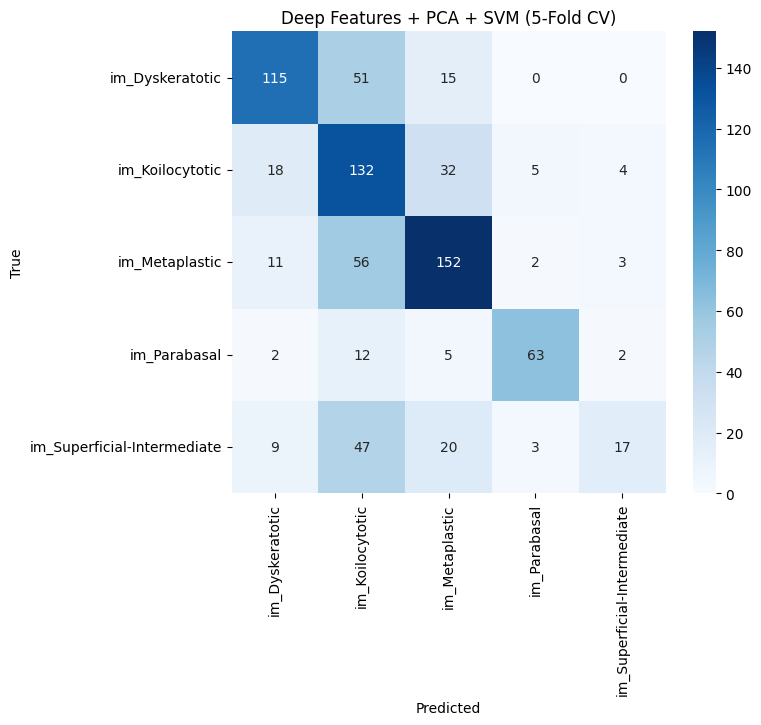

In [27]:
# 🔥 Code: Deep Features + PCA + SVM (5-Fold CV)

import os, random, math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------
# Settings
# -----------------------
DATASET_DIR = "/kaggle/working/split_dataset/train"  # your dataset path
IMG_SIZE = (80, 80)
BATCH_SIZE = 50
BASE_LR = 1e-4
MOMENTUM = 0.9
EPOCHS = 50       # shorter, since we just want features (not high softmax acc)
N_FOLDS = 5
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# -----------------------
# Load dataset
# -----------------------
classes = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])
class_to_idx = {c:i for i,c in enumerate(classes)}

X, y = [], []
for cls in classes:
    folder = os.path.join(DATASET_DIR, cls)
    for f in os.listdir(folder):
        if f.lower().endswith(('.png','.jpg','.jpeg','.bmp')):
            path = os.path.join(folder, f)
            img = tf.keras.preprocessing.image.load_img(path, target_size=IMG_SIZE)
            arr = tf.keras.preprocessing.image.img_to_array(img).astype("float32") / 255.0
            X.append(arr)
            y.append(class_to_idx[cls])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)
print("✅ Data:", X.shape, y.shape)

# -----------------------
# Flip augmentation (paper)
# -----------------------
def quadruple_with_flips(X_in, y_in):
    X_aug, y_aug = [], []
    for img, lbl in zip(X_in, y_in):
        X_aug.append(img); y_aug.append(lbl)
        X_aug.append(np.flip(img, axis=1)); y_aug.append(lbl)   # h-flip
        X_aug.append(np.flip(img, axis=0)); y_aug.append(lbl)   # v-flip
        X_aug.append(np.flip(np.flip(img,1),0)); y_aug.append(lbl)  # hv-flip
    return np.array(X_aug, dtype=np.float32), np.array(y_aug, dtype=np.int32)

# -----------------------
# Build VGG-like CNN
# -----------------------
def build_vgg_like(input_shape=(80,80,3), num_classes=5):
    inp = Input(shape=input_shape)
    x = inp
    # block1
    x = layers.Conv2D(64,3,padding="same",activation="relu")(x)
    x = layers.Conv2D(64,3,padding="same",activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    # block2
    x = layers.Conv2D(128,3,padding="same",activation="relu")(x)
    x = layers.Conv2D(128,3,padding="same",activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    # block3
    for _ in range(4): x = layers.Conv2D(256,3,padding="same",activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    # block4
    for _ in range(4): x = layers.Conv2D(512,3,padding="same",activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    # block5
    for _ in range(4): x = layers.Conv2D(512,3,padding="same",activation="relu")(x)
    conv5 = x
    x = layers.MaxPooling2D(2)(conv5)

    x = layers.Flatten()(x)
    fc6 = layers.Dense(4096, activation="relu", name="fc6")(x)
    x = layers.Dropout(0.5)(fc6)
    x = layers.Dense(4096, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = Model(inp, out)
    feat_model = Model(inp, [conv5, fc6])  # to extract conv5 & fc6
    return model, feat_model

# -----------------------
# Feature extractor
# -----------------------
def extract_features(feat_model, X_input, batch_size=64):
    conv5_list, fc6_list = [], []
    for i in range(0, len(X_input), batch_size):
        xb = X_input[i:i+batch_size]
        conv5, fc6 = feat_model.predict(xb, verbose=0)
        # conv5: (b,H,W,512) → sum pooling → (b,512)
        conv5_sum = np.sum(conv5, axis=(1,2))
        conv5_list.append(conv5_sum)
        fc6_list.append(fc6)
    return np.vstack(conv5_list), np.vstack(fc6_list)

# -----------------------
# Cross-validation
# -----------------------
all_true, all_pred = [], []
fold = 0
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for train_idx, test_idx in skf.split(X,y):
    fold += 1
    print(f"\n🔹 Fold {fold}/{N_FOLDS}")

    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    # flip augmentation on training
    X_tr_aug, y_tr_aug = quadruple_with_flips(X_tr, y_tr)
    print("Train size after augmentation:", X_tr_aug.shape)

    # build CNN
    cnn, feat_model = build_vgg_like(input_shape=IMG_SIZE+(3,), num_classes=len(classes))
    opt = SGD(learning_rate=BASE_LR, momentum=MOMENTUM)
    cnn.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    # train CNN (not for accuracy, just for features)
    cnn.fit(X_tr_aug, y_tr_aug,
            validation_data=(X_te, y_te),
            epochs=EPOCHS, batch_size=BATCH_SIZE,
            verbose=0, shuffle=True,
            callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)]
           )

    # extract deep features
    conv5_tr, fc6_tr = extract_features(feat_model, X_tr, batch_size=64)
    conv5_te, fc6_te = extract_features(feat_model, X_te, batch_size=64)

    # pick features (paper: conv5-sum + fc6)
    feats_tr = np.hstack([conv5_tr, fc6_tr])
    feats_te = np.hstack([conv5_te, fc6_te])

    # PCA → 256
    pca = PCA(n_components=256, random_state=SEED)
    feats_tr_pca = pca.fit_transform(feats_tr)
    feats_te_pca = pca.transform(feats_te)

    # scale
    scaler = StandardScaler()
    feats_tr_pca = scaler.fit_transform(feats_tr_pca)
    feats_te_pca = scaler.transform(feats_te_pca)

    # SVM classifier
    svm = SVC(kernel="rbf", C=10, gamma="scale")
    svm.fit(feats_tr_pca, y_tr)
    y_pred = svm.predict(feats_te_pca)

    # store results
    all_true.extend(y_te.tolist())
    all_pred.extend(y_pred.tolist())

    print("Fold report:")
    print(classification_report(y_te, y_pred, target_names=classes, digits=4))

# -----------------------
# Final results
# -----------------------
print("\n✅ Final aggregated report:")
print(classification_report(all_true, all_pred, target_names=classes, digits=4))
cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Deep Features + PCA + SVM (5-Fold CV)")
plt.show()

✅ Data: (776, 224, 224, 3) (776,)
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🔹 Fold 1/5
Features shape: (620, 1280)
Best SVM params: {'C': 10, 'gamma': 0.001}
Fold report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.8611    0.8378    0.8493        37
            im_Koilocytotic     0.8529    0.7632    0.8056        38
             im_Metaplastic     0.7800    0.8667    0.8211        45
               im_Parabasal     0.9412    1.0000    0.9697        16
im_Superficial-Intermediate     0.9474    0.9000    0.9231        20

                   accuracy                         0.8526       156
                  macro avg     0.8765    0.8735    0.8737       156
               weighted avg     0.8550    0.8526    0.8523       156


🔹 Fold 2/5
Features shape: (621, 1280)
Best SVM params: {'C': 10, 'gamma': 0.001}
Fold report:
                             precision    recall  f1-score   support

            im_Dyskeratotic    

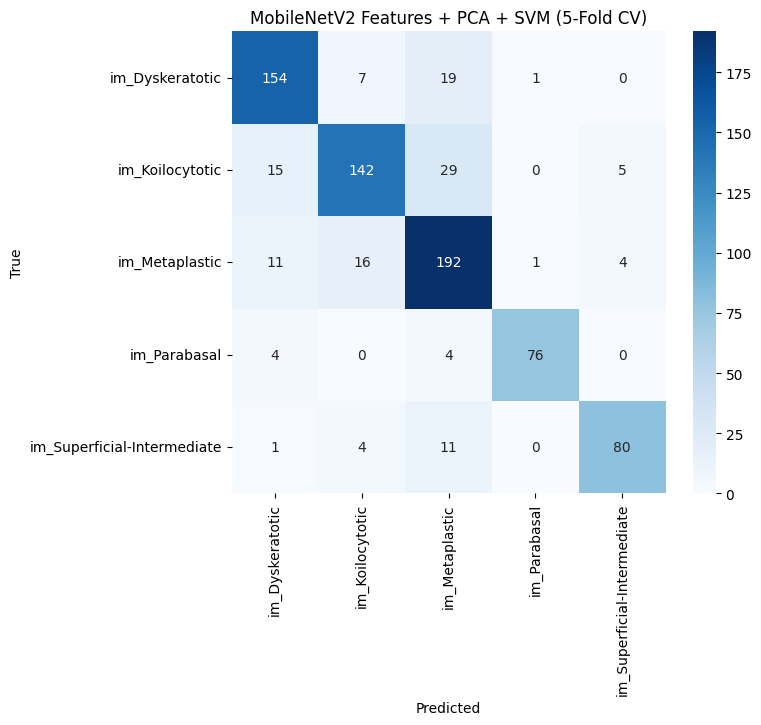

In [29]:
# ⚡ Code: MobileNetV2 Features → PCA → SVM (5-Fold CV)

import os, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------
# Settings
# -----------------------
DATASET_DIR = "/kaggle/working/split_dataset/train"  # your dataset path
IMG_SIZE = (224, 224)   # MobileNetV2 default
N_FOLDS = 5
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# -----------------------
# Load dataset
# -----------------------
classes = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])
class_to_idx = {c:i for i,c in enumerate(classes)}

X, y = [], []
for cls in classes:
    folder = os.path.join(DATASET_DIR, cls)
    for f in os.listdir(folder):
        if f.lower().endswith(('.png','.jpg','.jpeg','.bmp')):
            path = os.path.join(folder, f)
            img = tf.keras.preprocessing.image.load_img(path, target_size=IMG_SIZE)
            arr = tf.keras.preprocessing.image.img_to_array(img)
            arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)  # preprocessing
            X.append(arr)
            y.append(class_to_idx[cls])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)
print("✅ Data:", X.shape, y.shape)

# -----------------------
# Build MobileNetV2 feature extractor
# -----------------------
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,))
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
feature_model = Model(inputs=base_model.input, outputs=x)  # outputs 1280D feature vectors

# -----------------------
# Feature extraction function
# -----------------------
def extract_features(model, X_input, batch_size=64):
    feats = []
    for i in range(0, len(X_input), batch_size):
        xb = X_input[i:i+batch_size]
        f = model.predict(xb, verbose=0)
        feats.append(f)
    return np.vstack(feats)

# -----------------------
# Cross-validation with PCA + SVM
# -----------------------
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

all_true, all_pred = [], []
fold = 0

for train_idx, test_idx in skf.split(X,y):
    fold += 1
    print(f"\n🔹 Fold {fold}/{N_FOLDS}")

    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    # extract MobileNet features
    feats_tr = extract_features(feature_model, X_tr)
    feats_te = extract_features(feature_model, X_te)

    print("Features shape:", feats_tr.shape)

    # PCA → 256
    pca = PCA(n_components=256, random_state=SEED)
    feats_tr_pca = pca.fit_transform(feats_tr)
    feats_te_pca = pca.transform(feats_te)

    # scale
    scaler = StandardScaler()
    feats_tr_pca = scaler.fit_transform(feats_tr_pca)
    feats_te_pca = scaler.transform(feats_te_pca)

    # SVM with grid search (optimize hyperparams)
    param_grid = {"C": [1, 10, 50], "gamma": ["scale", 0.01, 0.001]}
    grid = GridSearchCV(SVC(kernel="rbf"), param_grid, cv=3, n_jobs=-1)
    grid.fit(feats_tr_pca, y_tr)

    svm_best = grid.best_estimator_
    print("Best SVM params:", grid.best_params_)

    y_pred = svm_best.predict(feats_te_pca)

    all_true.extend(y_te.tolist())
    all_pred.extend(y_pred.tolist())

    print("Fold report:")
    print(classification_report(y_te, y_pred, target_names=classes, digits=4))

# -----------------------
# Final results
# -----------------------
print("\n✅ Final aggregated report:")
print(classification_report(all_true, all_pred, target_names=classes, digits=4))
cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MobileNetV2 Features + PCA + SVM (5-Fold CV)")
plt.show()


✅ Data: (776, 224, 224, 3) (776,)

🔹 Fold 1/5
  ✅ CONV features report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.8889    0.8649    0.8767        37
            im_Koilocytotic     0.8571    0.7895    0.8219        38
             im_Metaplastic     0.8039    0.9111    0.8542        45
               im_Parabasal     0.9375    0.9375    0.9375        16
im_Superficial-Intermediate     0.9444    0.8500    0.8947        20

                   accuracy                         0.8654       156
                  macro avg     0.8864    0.8706    0.8770       156
               weighted avg     0.8688    0.8654    0.8654       156

  ✅ GAP features report:
                             precision    recall  f1-score   support

            im_Dyskeratotic     0.8889    0.8649    0.8767        37
            im_Koilocytotic     0.8571    0.7895    0.8219        38
             im_Metaplastic     0.8039    0.9111    0.8542        45
  

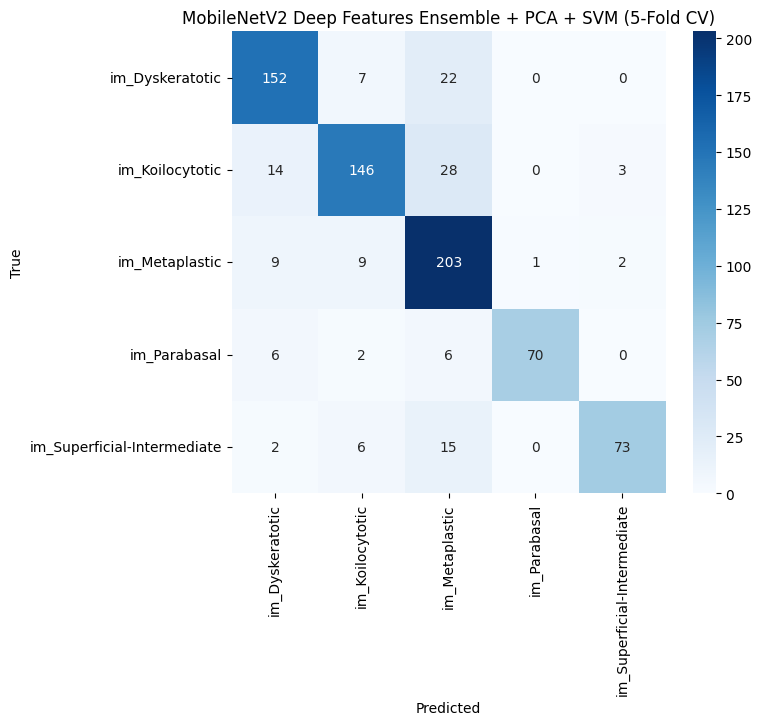

In [30]:
# ⚡ Code: MobileNetV2 Deep Features Ensemble + PCA + SVM (5-Fold CV)

import os, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------
# Settings
# -----------------------
DATASET_DIR = "/kaggle/working/split_dataset/train"
IMG_SIZE = (224, 224)
N_FOLDS = 5
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# -----------------------
# Load dataset
# -----------------------
classes = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])
class_to_idx = {c:i for i,c in enumerate(classes)}

X, y = [], []
for cls in classes:
    folder = os.path.join(DATASET_DIR, cls)
    for f in os.listdir(folder):
        if f.lower().endswith(('.png','.jpg','.jpeg','.bmp')):
            path = os.path.join(folder, f)
            img = tf.keras.preprocessing.image.load_img(path, target_size=IMG_SIZE)
            arr = tf.keras.preprocessing.image.img_to_array(img)
            arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
            X.append(arr)
            y.append(class_to_idx[cls])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)
print("✅ Data:", X.shape, y.shape)

# -----------------------
# Build MobileNetV2 feature extractor
# -----------------------
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,))
conv_output = base_model.output                        # (7x7x1280)
gap_output = tf.keras.layers.GlobalAveragePooling2D()(conv_output)  # 1280D
feature_model = Model(inputs=base_model.input, outputs=[conv_output, gap_output])

# -----------------------
# Feature extraction
# -----------------------
def extract_features(model, X_input, batch_size=64):
    conv_feats, gap_feats = [], []
    for i in range(0, len(X_input), batch_size):
        xb = X_input[i:i+batch_size]
        conv, gap = model.predict(xb, verbose=0)
        # sum-pool conv features: (b,7,7,1280) → (b,1280)
        conv_sum = np.sum(conv, axis=(1,2))
        conv_feats.append(conv_sum)
        gap_feats.append(gap)
    return np.vstack(conv_feats), np.vstack(gap_feats)

# -----------------------
# Cross-validation
# -----------------------
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

all_true, all_pred = [], []
fold = 0

for train_idx, test_idx in skf.split(X,y):
    fold += 1
    print(f"\n🔹 Fold {fold}/{N_FOLDS}")

    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    # extract deep features
    conv_tr, gap_tr = extract_features(feature_model, X_tr)
    conv_te, gap_te = extract_features(feature_model, X_te)

    # feature sets
    feats_tr_all = {
        "conv": conv_tr,
        "gap": gap_tr,
        "concat": np.hstack([conv_tr, gap_tr])
    }
    feats_te_all = {
        "conv": conv_te,
        "gap": gap_te,
        "concat": np.hstack([conv_te, gap_te])
    }

    preds_list = []

    for key in feats_tr_all.keys():
        # PCA → 256
        pca = PCA(n_components=256, random_state=SEED)
        feats_tr_pca = pca.fit_transform(feats_tr_all[key])
        feats_te_pca = pca.transform(feats_te_all[key])

        # scale
        scaler = StandardScaler()
        feats_tr_pca = scaler.fit_transform(feats_tr_pca)
        feats_te_pca = scaler.transform(feats_te_pca)

        # SVM
        svm = SVC(kernel="rbf", C=10, gamma="scale", probability=True)
        svm.fit(feats_tr_pca, y_tr)
        y_pred = svm.predict(feats_te_pca)
        preds_list.append(y_pred)

        print(f"  ✅ {key.upper()} features report:")
        print(classification_report(y_te, y_pred, target_names=classes, digits=4))

    # ensemble voting (majority)
    preds_stack = np.vstack(preds_list)  # shape: (n_models, n_samples)
    y_pred_ens = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 0, preds_stack)

    all_true.extend(y_te.tolist())
    all_pred.extend(y_pred_ens.tolist())

    print("  🔥 Ensemble report (conv+gap+concat):")
    print(classification_report(y_te, y_pred_ens, target_names=classes, digits=4))

# -----------------------
# Final results
# -----------------------
print("\n✅ Final aggregated ensemble report:")
print(classification_report(all_true, all_pred, target_names=classes, digits=4))
cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MobileNetV2 Deep Features Ensemble + PCA + SVM (5-Fold CV)")
plt.show()
